In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datajoint as dj
from learning_plasticity.kernelnet import KernelNet
from realnn.utils.dataset import Dataset
from realnn.utils.trainers import Trainer
%matplotlib inline
from learning_plasticity.schemas import shuang_kernel0 as sk

DataJoint 0.4.8 (January 24, 2017)
Connecting shuang@10.28.3.113:3306


In [ ]:
best_model_0 = sk.ModelSelection() & 'random_start = 0'& dj.U().aggr(sk.ModelSelection()& 'random_start = 0', val_error='min(val_error)')
best_model_0

In [ ]:
sk.InitBias()

In [3]:
model_test = sk.ModelSelection() & 'random_start = 1' & 'l1_id = 0' & 'l2_id = 0' & 'lr_id = 1' &'random_bias = 0'& 'seed = 607'& 'constant_seed = 0'
model_test

l1_id l1 regularization id,l2_id l1 regularization id,iterations number of iterations,"random_start 1 if random start, 0 if start from ground truth, seed is ignored when 0",seed random seed,lr_id,"jitters 1 if add jittering, 0 if not","random_bias 1 if with random bias initialization, 0 if start with constant",constant_seed random or constant intialization,bias bias of the model,val_error mse on validation set,val_loss total loss on validation set,pre_kernel calculated attribute,post_kernel calculated attribute
0,0,10,1,607,1,1,0,0,0.875168,0.0111374,0.0111374,=BLOB=,=BLOB=


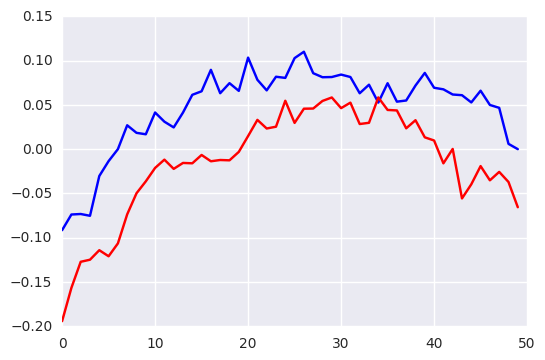

In [4]:
pre_ker, post_ker = model_test.fetch['pre_kernel', 'post_kernel']
plt.plot(pre_ker[0], 'b')
plt.plot(post_ker[0], 'r')

In [ ]:
pk = best_model_0.fetch1['pre_kernel']

In [6]:
key = model_test.fetch1[dj.key]

In [7]:
data_input = np.load('/data/data_input.npy')
target_final = np.load('/data/target_final.npy')
kernel_pre = np.load('/data/pre_kernel.npy')
kernel_post = np.load('/data/post_kernel.npy')
dataset = Dataset(inputs=data_input, targets=target_final)
train_inputs, train_targets = dataset.train_set()


In [8]:
net = KernelNet(n_input=train_inputs.shape[1], kernel_pre=kernel_pre, kernel_post=kernel_post,
                  if_rand_ini=key['random_start'], if_rand_bias=key['random_bias'],
                   rand_seed=[key['seed'], key['seed'] + 1, key['constant_seed']])

In [9]:
trainer = Trainer(net.cost, net.input_, net.target_, net.is_training_,
                          optimizer_config={'learning_rate': net.l_rate_})

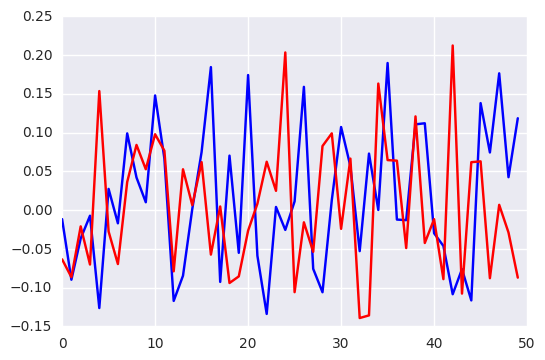

In [10]:
wc_pre = np.hstack(trainer.evaluate(ops=net.wc_pre))
wc_post = np.hstack(trainer.evaluate(ops=net.wc_post))
plt.plot(wc_pre[0], 'b')
plt.plot(wc_post[0], 'r')

In [ ]:
lr = (sk.LearningRate() & key).fetch1['learning_rate']

# Strength of L1 normalization
alpha1 = (sk.L1RegConstant() & key).fetch1['alpha_l1']
alpha2 = (sk.L2RegConstant() & key).fetch1['alpha_l2']
trainer.min_total_loss = trainer.evaluate(dataset.validation_inputs, dataset.validation_targets,feed_dict={net.l_rate_: lr, net.alpha1_: alpha1, net.alpha2_: alpha2})
trainer.save_best()
# Epochs of training
for i in range(key['iterations']):
    trainer.train(dataset, batch_size=128, max_steps=-1, early_stopping_steps=20,save_freq=-1,feed_dict={net.l_rate_: lr, net.alpha1_: alpha1, net.alpha2_: alpha2}, test_freq=0)
    lr /= 3

In [ ]:
wc_pre = np.hstack(trainer.evaluate(ops=net.wc_pre))
wc_post = np.hstack(trainer.evaluate(ops=net.wc_post))

In [ ]:
plt.plot(wc_pre.squeeze())
plt.plot(wc_post.squeeze())

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(5, 3), sharex = True, sharey = True)
for  val, ax in zip(model_test.fetch.as_dict.order_by('constant_seed'), axs.ravel()):
    ax.plot(val['pre_kernel'])
    ax.plot(val['post_kernel'], 'r')
    ax.set_title(r'$\alpha_l1$={l1_id} $\alpha_l2$={l2_id} bias_id={constant_seed}'.format(**val))
    ax.set_xlabel('error={val_error} lr_id = {lr_id}'.format(**val))
fig.tight_layout()